In [7]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
import cv2

from PIL import Image
import pickle


import tensorflow as tf

In [1]:
# Importing packages

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
import cv2

from PIL import Image
import pickle


import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
import sys
import platform
import tensorflow as tf


def get_installed_packages():
    installed_packages = []
    for package in sorted(sys.modules):
        if hasattr(sys.modules[package], "__version__"):
            version = sys.modules[package].__version__
            installed_packages.append((package, version))
    return installed_packages

def main():
    print("Python Version:", sys.version)
    print("Operating System:", platform.system(), platform.release())
    
    print("\nInstalled Packages:")
    installed_packages = get_installed_packages()
    for package, version in installed_packages:
        print(f"{package} - {version}")
    
    print("\nTensorFlow GPU build information:\n", tf.sysconfig.get_build_info())
    
    try:
        gpu_device = tf.config.list_physical_devices('GPU')[0]
        print("CUDA Version:", tf.config.experimental.get_device_details(gpu_device)['driver_version'])
        print("cuDNN Version:", tf.config.experimental.get_device_details(gpu_device)['cudnn_version'])
    except:
        print("No GPU found or unable to retrieve GPU information.")

    

if __name__ == "__main__":
    main()


Python Version: 3.7.0 (v3.7.0:1bf9cc5093, Jun 27 2018, 04:59:51) [MSC v.1914 64 bit (AMD64)]
Operating System: Windows 10

Installed Packages:
IPython - 7.34.0
IPython.core.release - 7.34.0
PIL - 9.5.0
PIL.Image - 9.5.0
PIL._deprecate - 9.5.0
PIL._version - 9.5.0
_csv - 1.0
_ctypes - 1.1.0
_decimal - 1.70
_pydev_bundle.fsnotify - 0.1.5
_pydevd_frame_eval.vendored.bytecode - 0.13.0.dev
argparse - 1.1
astunparse - 1.6.3
backcall - 0.2.0
certifi - 2023.05.07
charset_normalizer - 3.1.0
charset_normalizer.version - 3.1.0
colorama - 0.4.6
csv - 1.0
ctypes - 1.1.0
cv2 - 4.7.0
cycler - 0.10.0
dateutil - 2.8.2
debugpy - 1.6.7
debugpy.public_api - 1.6.7
decimal - 1.70
decorator - 5.1.1
distutils - 3.7.0
entrypoints - 0.4
flatbuffers - 23.5.26
flatbuffers._version - 23.5.26
google.protobuf - 3.19.6
h5py - 3.8.0
http.server - 0.6
idna - 3.4
idna.idnadata - 15.0.0
idna.package_data - 3.4
ipaddress - 1.0
ipykernel - 6.16.2
ipykernel._version - 6.16.2
jedi - 0.18.2
json - 2.0.9
jupyter_client - 7.4.9

In [8]:
def load_and_preprocess_image(image_path):
    # Implement your image loading and preprocessing logic here
    # This function should return a preprocessed image tensor
    #img=tf.strings.as_string(image_path)
    img=tf.io.read_file(image_path)
    img=tf.image.decode_jpeg(img)
    img=img/255
    img=tf.image.resize(img, [64,64])
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    
    return img

def load_and_preprocess_label(label_path):
    # Implement your label loading and preprocessing logic here
    # This function should return a preprocessed label tensor

    label=tf.io.read_file(label_path)
    label=tf.strings.to_number(label)
    label=label/1000
    label = tf.convert_to_tensor(label, dtype=tf.float32)
    
    return label


window_size=120
stride=136
test_seq_path=r"C:\Users\HP\Desktop\Projet Stage 2A L'hamdi\forecasting modes\data\test_seq"
test_img_dataset=tf.data.Dataset.list_files(r"C:\Users\HP\Desktop\Projet Stage 2A L'hamdi\forecasting modes\data\test_seq/*/images/*", shuffle=False)
test_img_dataset=test_img_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_img_dataset=test_img_dataset.window(window_size, shift=stride, drop_remainder=True).flat_map(lambda x: x.batch(window_size))
test_img_dataset=test_img_dataset.batch(8).cache('test_cache_img_folder').prefetch(tf.data.AUTOTUNE)

test_label_dataset=tf.data.Dataset.list_files(r"C:\Users\HP\Desktop\Projet Stage 2A L'hamdi\forecasting modes\data\test_seq/*/labels/*", shuffle=False)
test_label_dataset=test_label_dataset.map(load_and_preprocess_label).window(window_size, shift=stride, drop_remainder=True)
test_label_dataset=test_label_dataset.flat_map(lambda x: x.batch(window_size))
test_label_dataset=test_label_dataset.batch(8).cache('test_cache_lbl_folder').prefetch(tf.data.AUTOTUNE)

In [9]:
window_size = 120  # Define the window size
stride = 136 

y=[]
for ds in tf.data.Dataset.list_files(r"C:\Users\HP\Desktop\Projet Stage 2A L'hamdi\forecasting modes\data\test_seq/*/labels/*", shuffle=False).map(load_and_preprocess_label).window(16, shift=136, drop_remainder=True):
    for element in ds:
        #print(element.numpy())
        y.append(element.numpy())

In [10]:
len(y) #avec le take c 5632 et sans le take c la meme chose

5632

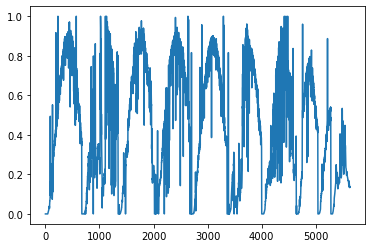

In [11]:
plt.plot(y)

# 1- **Evaluating model 1_arch_1 LSTM+CONV2D 1.8M param**


In [12]:
model=tf.keras.models.load_model(r"C:\Users\HP\Desktop\Projet Stage 2A L'hamdi\forecasting modes\data\Final models\forecasting using img+pirp\using CONV2D + LSTM\Forecast 1.8M param LSTM.h5")
test_data= tf.data.Dataset.zip((test_img_dataset, test_label_dataset))

y_hat = []
for img_batch, label_batch in test_data:
    predictions = model.predict((img_batch, label_batch))
    y_hat.extend(predictions)

yz=np.array(y_hat).reshape(-1)*1000

1/1 [==============================] - 4s 4s/step


Text(0.5, 1.0, 'Irradiance actuelle')

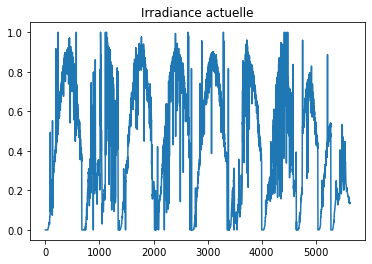

In [13]:
y_actual=y
y_predicted=yz
plt.plot(y_actual)
plt.title("Irradiance actuelle")

Text(0.5, 1.0, 'Model CONV+LSTM 1.8M')

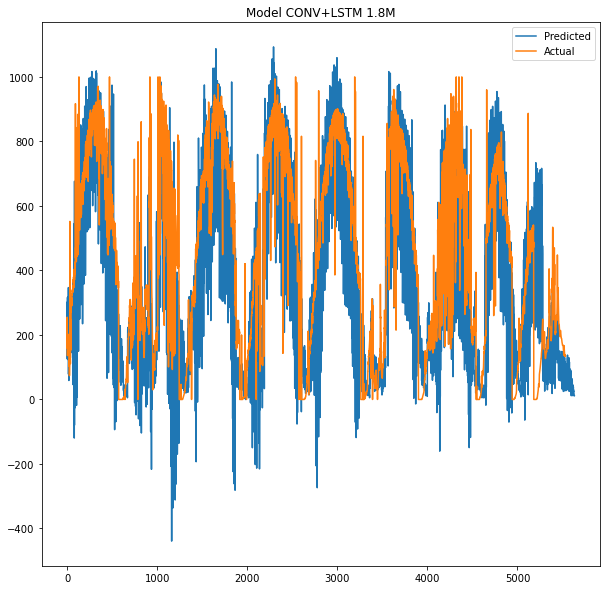

In [14]:
y_actual=np.array(y)*1000
plt.figure(figsize=(10,10))
plt.plot(y_predicted[:],label="Predicted")
plt.plot(y_actual[100:],label="Actual")

plt.legend()
plt.title("Model CONV+LSTM 1.8M")

Text(0.5, 1.0, 'Model CONV+LSTM 1.8M')

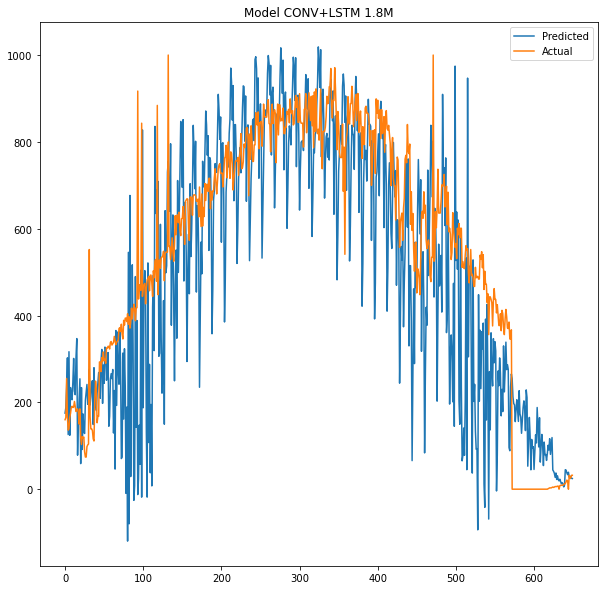

In [15]:
y_actual=np.array(y)*1000
plt.figure(figsize=(10,10))
plt.plot(y_predicted[:650],label="Predicted")
plt.plot(y_actual[100:750],label="Actual")

plt.legend()
plt.title("Model CONV+LSTM 1.8M")

In [16]:
print(y_actual[100:].shape)
print(y_predicted[:-100].shape)

(5532,)
(5532,)


In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
L=[]
for a in range(10,1000):
    y_actual_2=y_actual[a:5400]
    y_pred_2=yz[:5400-a]
    # Assuming you have both arrays y_pred and y_actual
    #print("for model 1 CONV+LSTM+GRU")
    #print("Here are the metrics for the test set: ")
    #print("")
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_actual_2, y_pred_2)
    #print("Mean Absolute Error (MAE):", mae)
    L.append(mae)

min_value = min(L)

# Find the index of the minimum value
min_index = L.index(min_value)

print(min_value,min_index)


152.02415 96


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_actual_2=y_actual[110:5400]
y_pred_2=yz[:5400-110]
# Assuming you have both arrays y_pred and y_actual
print("for model 1 CONV+LSTM 1.8M")
print("Here are the metrics for the test set: ")
print("")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_actual_2, y_pred_2)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_actual_2, y_pred_2)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R2)
r2 = r2_score(y_actual_2, y_pred_2)
print("R-squared (R2):", r2)

for model 1 CONV+LSTM 1.8M
Here are the metrics for the test set: 

Mean Absolute Error (MAE): 153.47911
Mean Squared Error (MSE): 44448.938
Root Mean Squared Error (RMSE): 210.82916
R-squared (R2): 0.49483139833999157


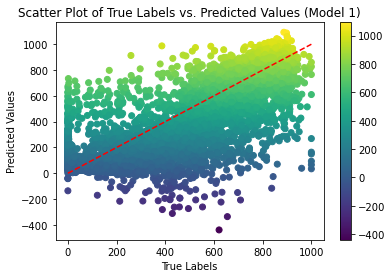

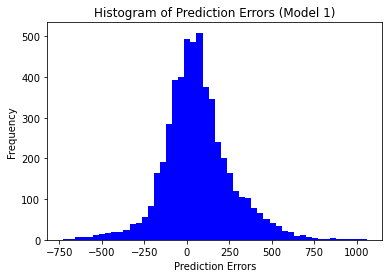

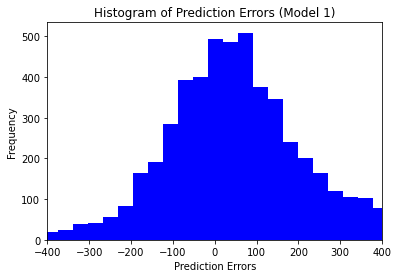

Nombre de points dans l echantillon est  5632


In [26]:
import matplotlib.pyplot as plt

# Create a scatter plot of predicted values vs. true labels
plt.scatter(y_actual_2, y_pred_2, c=y_pred_2, cmap='viridis')
plt.xlabel("True Labels")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot of True Labels vs. Predicted Values (Model 1)")
plt.colorbar()
# Add the diagonal line (y = x) for perfect prediction
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')
plt.show()

# Create a histogram of prediction errors
errors = y_actual_2 - y_pred_2
plt.hist(errors, bins=50, color='blue')
plt.xlabel("Prediction Errors")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors (Model 1)")

plt.show()

errors = y_actual_2 - y_pred_2
plt.hist(errors, bins=50, color='blue')
plt.xlabel("Prediction Errors")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors (Model 1)")
plt.xlim(-400, 400)
plt.show()

print("Nombre de points dans l echantillon est ", len(y_actual))

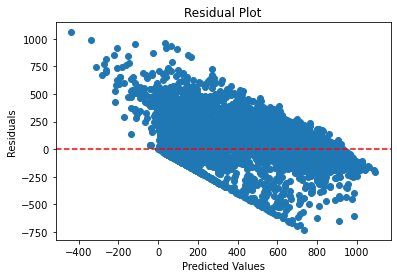

In [27]:
# Calculate residuals
residuals = y_actual_2 - y_pred_2

# Create a residual plot
plt.scatter(y_pred_2, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


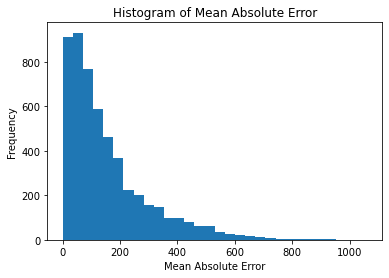

In [28]:
# Calculate Mean Absolute Error (MAE) for each sample
mae_per_sample = np.abs(y_actual_2 - y_pred_2)

# Create a histogram of MAE
plt.hist(mae_per_sample, bins=30)
plt.xlabel("Mean Absolute Error")
plt.ylabel("Frequency")
plt.title("Histogram of Mean Absolute Error")
plt.show()


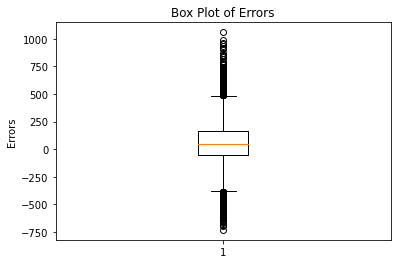

In [29]:
# Create a box plot of errors
plt.boxplot(errors)
plt.ylabel("Errors")
plt.title("Box Plot of Errors")
plt.show()

# 2- **Evaluating model 2_arch_1 LSTM+CONV2D 2.7M param**


In [30]:
model=tf.keras.models.load_model(r"C:\Users\HP\Desktop\Projet Stage 2A L'hamdi\forecasting modes\data\Final models\forecasting using img+pirp\using CONV2D + LSTM\forecast_model.h5")
test_data= tf.data.Dataset.zip((test_img_dataset, test_label_dataset))

y_hat = []
for img_batch, label_batch in test_data:
    predictions = model.predict((img_batch, label_batch))
    y_hat.extend(predictions)

yz=np.array(y_hat).reshape(-1)*1000

1/1 [==============================] - 1s 1s/step


Text(0.5, 1.0, 'Irradiance actuelle')

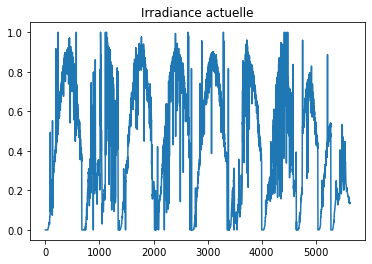

In [31]:
y_actual=y
y_predicted=yz
plt.plot(y_actual)
plt.title("Irradiance actuelle")

Text(0.5, 1.0, 'Model CONV+LSTM 2.7M')

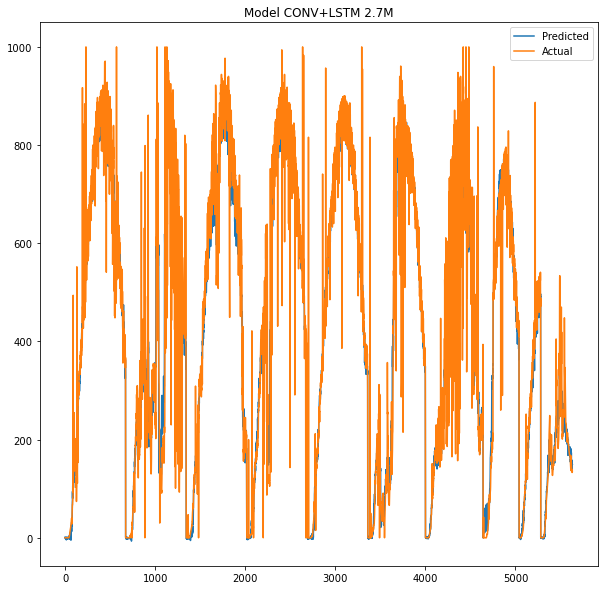

In [38]:
y_actual=np.array(y)*1000
plt.figure(figsize=(10,10))
plt.plot(y_predicted[:],label="Predicted")
plt.plot(y_actual[:],label="Actual")

plt.legend()
plt.title("Model CONV+LSTM 2.7M")

Text(0.5, 1.0, 'Model CONV+LSTM 2.7M')

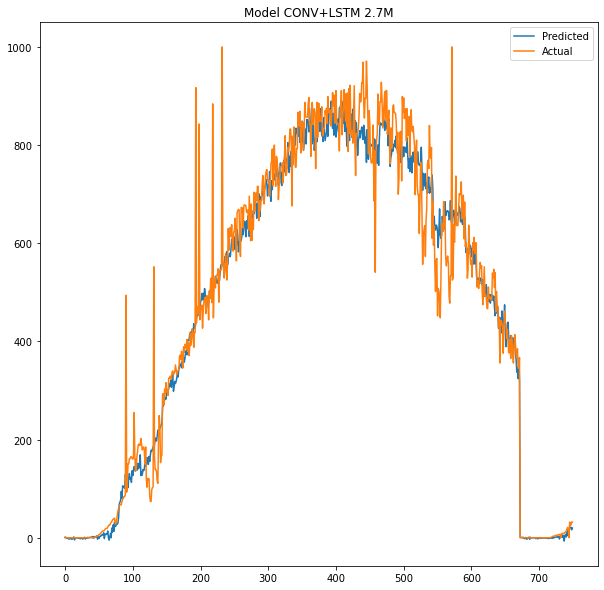

In [37]:
y_actual=np.array(y)*1000
plt.figure(figsize=(10,10))
plt.plot(y_predicted[:750],label="Predicted")
plt.plot(y_actual[:750],label="Actual")

plt.legend()
plt.title("Model CONV+LSTM 2.7M")

Text(0.5, 1.0, 'Model CONV+LSTM 2.7M')

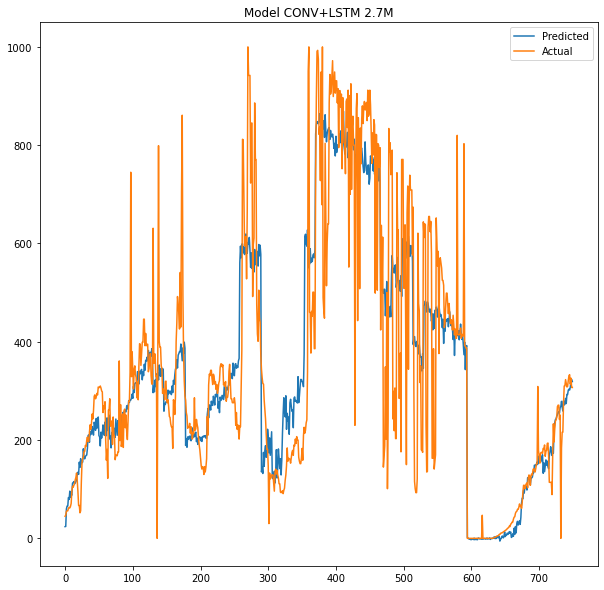

In [44]:
y_actual=np.array(y)*1000
plt.figure(figsize=(10,10))
plt.plot(y_predicted[750:1500],label="Predicted")
plt.plot(y_actual[750:1500],label="Actual")

plt.legend()
plt.title("Model CONV+LSTM 2.7M")

Text(0.5, 1.0, 'Model CONV+LSTM 2.7M')

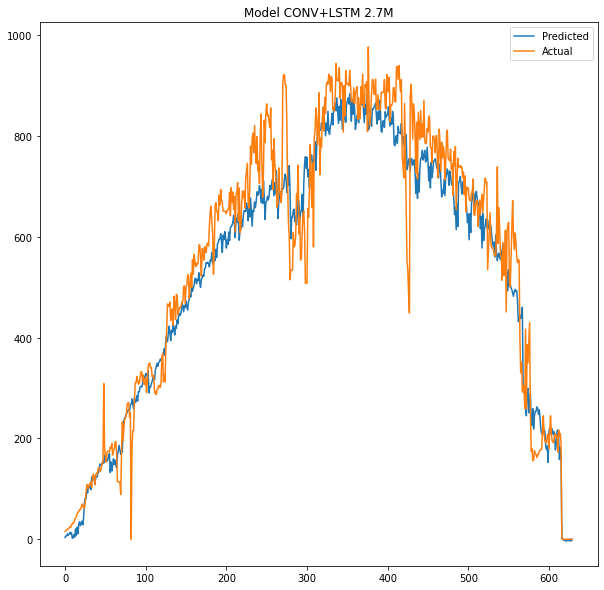

In [50]:
y_actual=np.array(y)*1000
plt.figure(figsize=(10,10))
plt.plot(y_predicted[1400:2030],label="Predicted")
plt.plot(y_actual[1400:2030],label="Actual")

plt.legend()
plt.title("Model CONV+LSTM 2.7M")

In [51]:
print(y_actual[100:].shape)
print(y_predicted[:-100].shape)

(5532,)
(5532,)


In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
L=[]
for a in range(10,1000):
    y_actual_2=y_actual[a:5400]
    y_pred_2=yz[:5400-a]
    # Assuming you have both arrays y_pred and y_actual
    #print("for model 1 CONV+LSTM+GRU")
    #print("Here are the metrics for the test set: ")
    #print("")
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_actual_2, y_pred_2)
    #print("Mean Absolute Error (MAE):", mae)
    L.append(mae)

min_value = min(L)

# Find the index of the minimum value
min_index = L.index(min_value)

print(min_value,min_index)


66.14933 0


In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_actual_2=y_actual[:5400]
y_pred_2=yz[:5400]
# Assuming you have both arrays y_pred and y_actual
print("for model 2 CONV+LSTM 2.7M")
print("Here are the metrics for the test set: ")
print("")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_actual_2, y_pred_2)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_actual_2, y_pred_2)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R2)
r2 = r2_score(y_actual_2, y_pred_2)
print("R-squared (R2):", r2)

for model 2 CONV+LSTM 2.7M
Here are the metrics for the test set: 

Mean Absolute Error (MAE): 53.43065
Mean Squared Error (MSE): 8231.057
Root Mean Squared Error (RMSE): 90.725174
R-squared (R2): 0.908252423462345


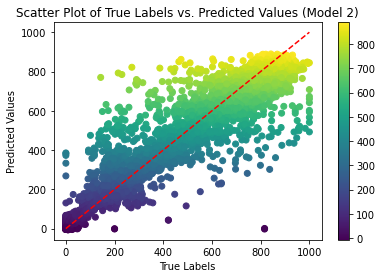

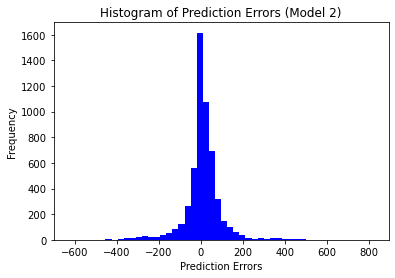

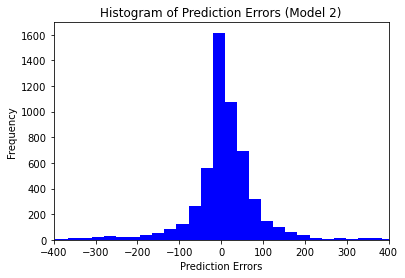

Nombre de points dans l echantillon est  5632


In [54]:
import matplotlib.pyplot as plt

# Create a scatter plot of predicted values vs. true labels
plt.scatter(y_actual_2, y_pred_2, c=y_pred_2, cmap='viridis')
plt.xlabel("True Labels")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot of True Labels vs. Predicted Values (Model 2)")
plt.colorbar()
# Add the diagonal line (y = x) for perfect prediction
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')
plt.show()

# Create a histogram of prediction errors
errors = y_actual_2 - y_pred_2
plt.hist(errors, bins=50, color='blue')
plt.xlabel("Prediction Errors")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors (Model 2)")

plt.show()

errors = y_actual_2 - y_pred_2
plt.hist(errors, bins=50, color='blue')
plt.xlabel("Prediction Errors")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors (Model 2)")
plt.xlim(-400, 400)
plt.show()

print("Nombre de points dans l echantillon est ", len(y_actual))

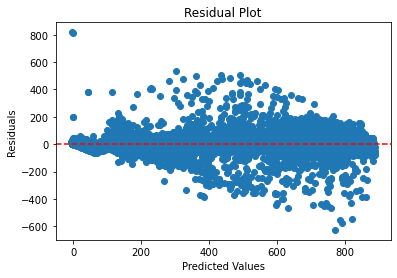

In [55]:
# Calculate residuals
residuals = y_actual_2 - y_pred_2

# Create a residual plot
plt.scatter(y_pred_2, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


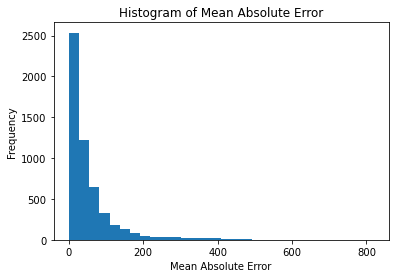

In [56]:
# Calculate Mean Absolute Error (MAE) for each sample
mae_per_sample = np.abs(y_actual_2 - y_pred_2)

# Create a histogram of MAE
plt.hist(mae_per_sample, bins=30)
plt.xlabel("Mean Absolute Error")
plt.ylabel("Frequency")
plt.title("Histogram of Mean Absolute Error")
plt.show()


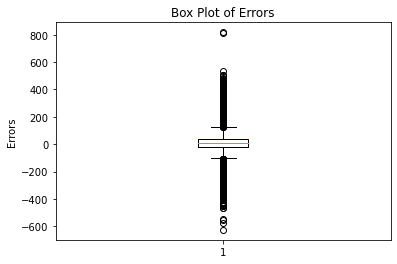

In [57]:
# Create a box plot of errors
plt.boxplot(errors)
plt.ylabel("Errors")
plt.title("Box Plot of Errors")
plt.show()

# 3- **Evaluating model 3_arch_1 LSTM+CONV2D 4.5M param**


In [58]:
model=tf.keras.models.load_model(r"C:\Users\HP\Desktop\Projet Stage 2A L'hamdi\forecasting modes\data\Final models\forecasting using img+pirp\using CONV2D + LSTM\forecast.4.5M param.h5")
test_data= tf.data.Dataset.zip((test_img_dataset, test_label_dataset))

y_hat = []
for img_batch, label_batch in test_data:
    predictions = model.predict((img_batch, label_batch))
    y_hat.extend(predictions)

yz=np.array(y_hat).reshape(-1)*1000

1/1 [==============================] - 1s 1s/step


Text(0.5, 1.0, 'Irradiance actuelle')

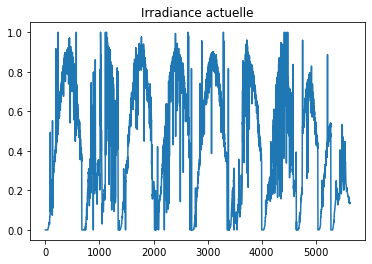

In [59]:
y_actual=y
y_predicted=yz
plt.plot(y_actual)
plt.title("Irradiance actuelle")

Text(0.5, 1.0, 'Model CONV+LSTM 4.5M')

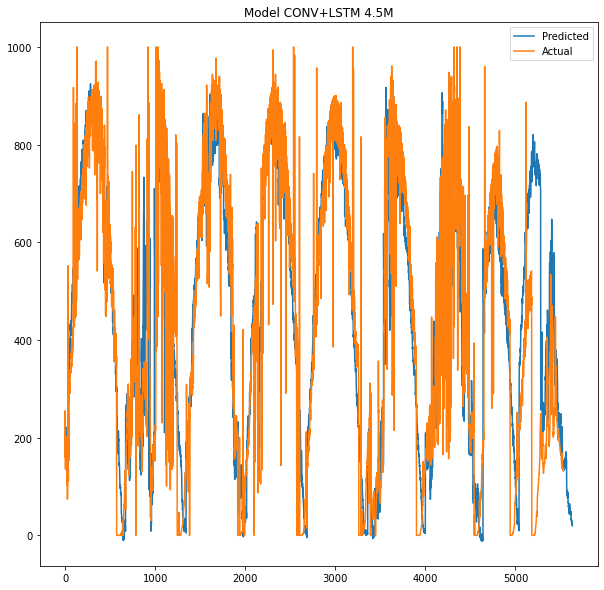

In [62]:
y_actual=np.array(y)*1000
plt.figure(figsize=(10,10))
plt.plot(y_predicted[:],label="Predicted")
plt.plot(y_actual[100:],label="Actual")

plt.legend()
plt.title("Model CONV+LSTM 4.5M")

Text(0.5, 1.0, 'Model CONV+LSTM 4.5M')

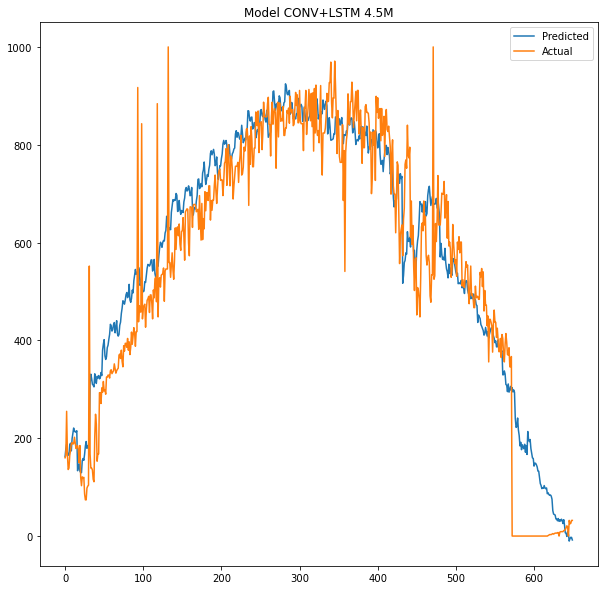

In [63]:
y_actual=np.array(y)*1000
plt.figure(figsize=(10,10))
plt.plot(y_predicted[:650],label="Predicted")
plt.plot(y_actual[100:750],label="Actual")

plt.legend()
plt.title("Model CONV+LSTM 4.5M")

Text(0.5, 1.0, 'Model CONV+LSTM 4.5M')

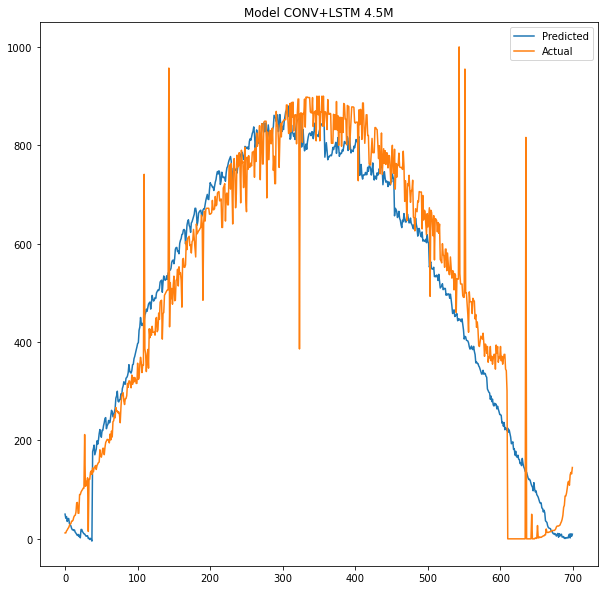

In [70]:
y_actual=np.array(y)*1000
plt.figure(figsize=(10,10))
plt.plot(y_predicted[2650:3350],label="Predicted")
plt.plot(y_actual[2750:3450],label="Actual")

plt.legend()
plt.title("Model CONV+LSTM 4.5M")

In [71]:
print(y_actual[100:].shape)
print(y_predicted[:-100].shape)

(5532,)
(5532,)


In [72]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
L=[]
for a in range(10,1000):
    y_actual_2=y_actual[a:5400]
    y_pred_2=yz[:5400-a]
    # Assuming you have both arrays y_pred and y_actual
    #print("for model 1 CONV+LSTM+GRU")
    #print("Here are the metrics for the test set: ")
    #print("")
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_actual_2, y_pred_2)
    #print("Mean Absolute Error (MAE):", mae)
    L.append(mae)

min_value = min(L)

# Find the index of the minimum value
min_index = L.index(min_value)

print(min_value,min_index)


104.55547 104


In [75]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_actual_2=y_actual[110:5400]
y_pred_2=yz[:5400-110]
# Assuming you have both arrays y_pred and y_actual
print("for model 3 CONV+LSTM 4.5M")
print("Here are the metrics for the test set: ")
print("")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_actual_2, y_pred_2)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_actual_2, y_pred_2)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R2)
r2 = r2_score(y_actual_2, y_pred_2)
print("R-squared (R2):", r2)

for model 3 CONV+LSTM 4.5M
Here are the metrics for the test set: 

Mean Absolute Error (MAE): 107.36219
Mean Squared Error (MSE): 27836.582
Root Mean Squared Error (RMSE): 166.84299
R-squared (R2): 0.6836332471268117


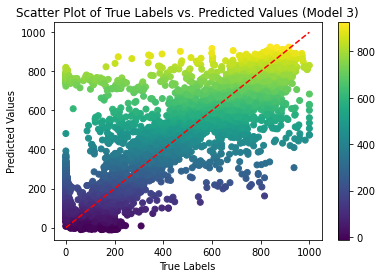

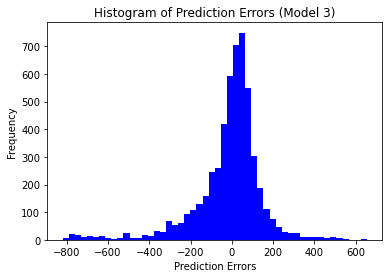

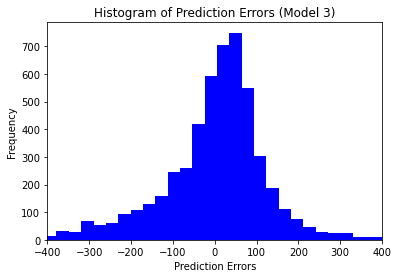

Nombre de points dans l echantillon est  5632


In [76]:
import matplotlib.pyplot as plt

# Create a scatter plot of predicted values vs. true labels
plt.scatter(y_actual_2, y_pred_2, c=y_pred_2, cmap='viridis')
plt.xlabel("True Labels")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot of True Labels vs. Predicted Values (Model 3)")
plt.colorbar()
# Add the diagonal line (y = x) for perfect prediction
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')
plt.show()

# Create a histogram of prediction errors
errors = y_actual_2 - y_pred_2
plt.hist(errors, bins=50, color='blue')
plt.xlabel("Prediction Errors")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors (Model 3)")

plt.show()

errors = y_actual_2 - y_pred_2
plt.hist(errors, bins=50, color='blue')
plt.xlabel("Prediction Errors")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors (Model 3)")
plt.xlim(-400, 400)
plt.show()

print("Nombre de points dans l echantillon est ", len(y_actual))

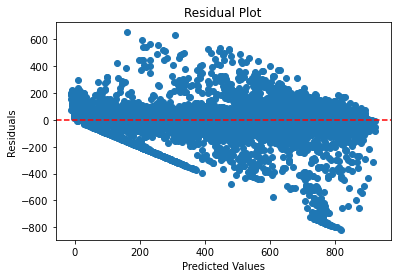

In [77]:
# Calculate residuals
residuals = y_actual_2 - y_pred_2

# Create a residual plot
plt.scatter(y_pred_2, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


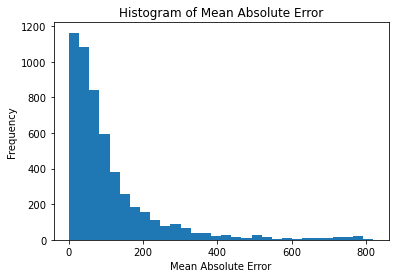

In [79]:
# Calculate Mean Absolute Error (MAE) for each sample
mae_per_sample = np.abs(y_actual_2 - y_pred_2)

# Create a histogram of MAE
plt.hist(mae_per_sample, bins=30)
plt.xlabel("Mean Absolute Error")
plt.ylabel("Frequency")
plt.title("Histogram of Mean Absolute Error")
plt.show()


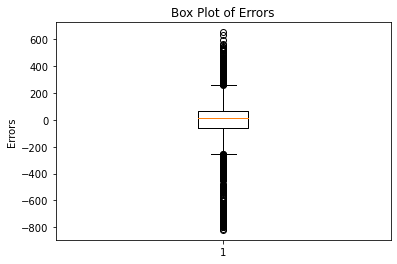

In [80]:
# Create a box plot of errors
plt.boxplot(errors)
plt.ylabel("Errors")
plt.title("Box Plot of Errors")
plt.show()

# 4- **Evaluating model 4_arch_1 LSTM+CONV2D 7M param**


In [81]:
model=tf.keras.models.load_model(r"C:\Users\HP\Desktop\Projet Stage 2A L'hamdi\forecasting modes\data\Final models\forecasting using img+pirp\using CONV2D + LSTM\model.forecast_7M param.h5")
test_data= tf.data.Dataset.zip((test_img_dataset, test_label_dataset))

y_hat = []
for img_batch, label_batch in test_data:
    predictions = model.predict((img_batch, label_batch))
    y_hat.extend(predictions)

yz=np.array(y_hat).reshape(-1)*1000

1/1 [==============================] - 3s 3s/step


Text(0.5, 1.0, 'Irradiance actuelle')

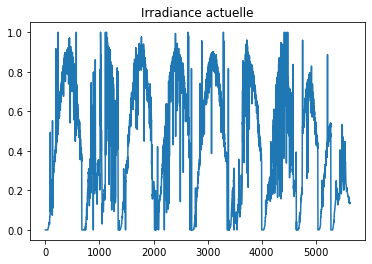

In [82]:
y_actual=y
y_predicted=yz
plt.plot(y_actual)
plt.title("Irradiance actuelle")

Text(0.5, 1.0, 'Model CONV+LSTM 7M')

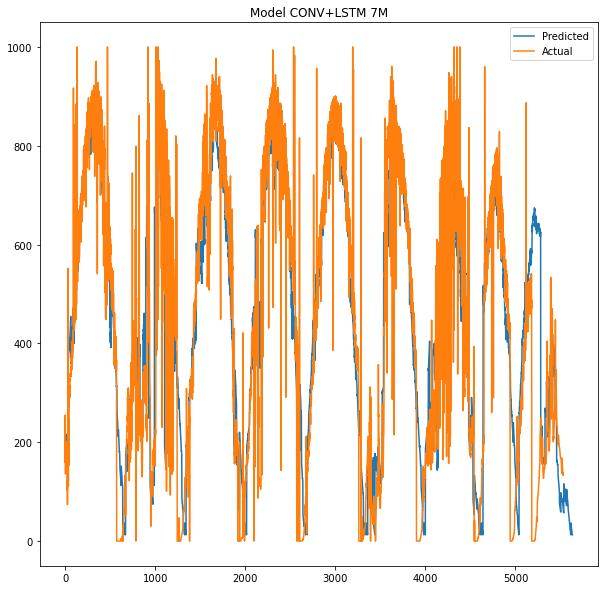

In [83]:
y_actual=np.array(y)*1000
plt.figure(figsize=(10,10))
plt.plot(y_predicted[:],label="Predicted")
plt.plot(y_actual[100:],label="Actual")

plt.legend()
plt.title("Model CONV+LSTM 7M")

Text(0.5, 1.0, 'Model CONV+LSTM 7M')

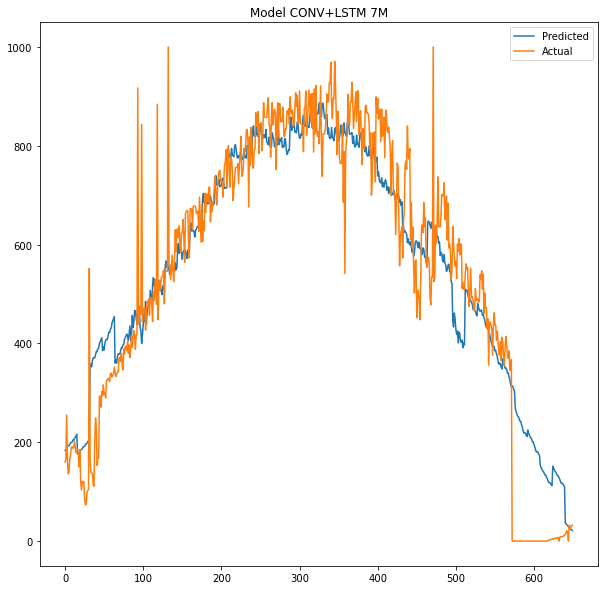

In [86]:
y_actual=np.array(y)*1000
plt.figure(figsize=(10,10))
plt.plot(y_predicted[:650],label="Predicted")
plt.plot(y_actual[100:750],label="Actual")

plt.legend()
plt.title("Model CONV+LSTM 7M")

In [87]:
print(y_actual[100:].shape)
print(y_predicted[:-100].shape)

(5532,)
(5532,)


In [88]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
L=[]
for a in range(10,1000):
    y_actual_2=y_actual[a:5400]
    y_pred_2=yz[:5400-a]
    # Assuming you have both arrays y_pred and y_actual
    #print("for model 1 CONV+LSTM+GRU")
    #print("Here are the metrics for the test set: ")
    #print("")
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_actual_2, y_pred_2)
    #print("Mean Absolute Error (MAE):", mae)
    L.append(mae)

min_value = min(L)

# Find the index of the minimum value
min_index = L.index(min_value)

print(min_value,min_index)


102.03558 100


In [89]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_actual_2=y_actual[110:5400]
y_pred_2=yz[:5400-110]
# Assuming you have both arrays y_pred and y_actual
print("for model 4 CONV+LSTM 7M")
print("Here are the metrics for the test set: ")
print("")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_actual_2, y_pred_2)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_actual_2, y_pred_2)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R2)
r2 = r2_score(y_actual_2, y_pred_2)
print("R-squared (R2):", r2)

for model 4 CONV+LSTM 7M
Here are the metrics for the test set: 

Mean Absolute Error (MAE): 102.03558
Mean Squared Error (MSE): 22936.451
Root Mean Squared Error (RMSE): 151.44785
R-squared (R2): 0.7393239098565612


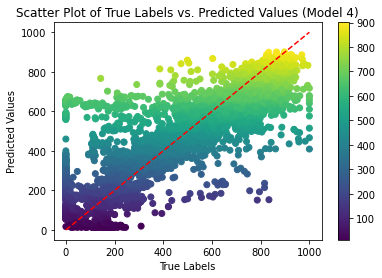

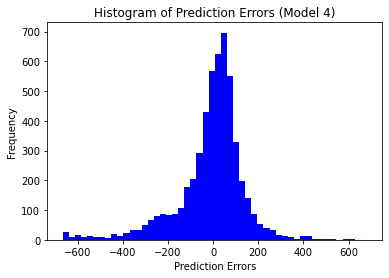

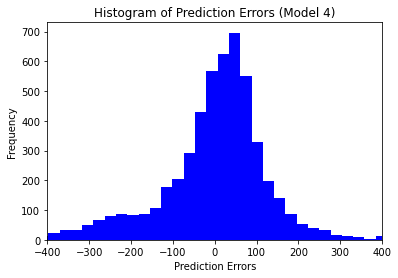

Nombre de points dans l echantillon est  5632


In [90]:
import matplotlib.pyplot as plt

# Create a scatter plot of predicted values vs. true labels
plt.scatter(y_actual_2, y_pred_2, c=y_pred_2, cmap='viridis')
plt.xlabel("True Labels")
plt.ylabel("Predicted Values")
plt.title("Scatter Plot of True Labels vs. Predicted Values (Model 4)")
plt.colorbar()
# Add the diagonal line (y = x) for perfect prediction
plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='--')
plt.show()

# Create a histogram of prediction errors
errors = y_actual_2 - y_pred_2
plt.hist(errors, bins=50, color='blue')
plt.xlabel("Prediction Errors")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors (Model 4)")

plt.show()

errors = y_actual_2 - y_pred_2
plt.hist(errors, bins=50, color='blue')
plt.xlabel("Prediction Errors")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors (Model 4)")
plt.xlim(-400, 400)
plt.show()

print("Nombre de points dans l echantillon est ", len(y_actual))

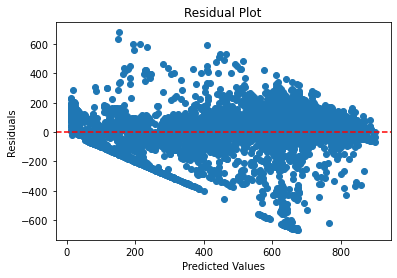

In [91]:
# Calculate residuals
residuals = y_actual_2 - y_pred_2

# Create a residual plot
plt.scatter(y_pred_2, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


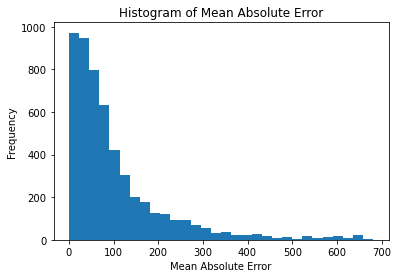

In [92]:
# Calculate Mean Absolute Error (MAE) for each sample
mae_per_sample = np.abs(y_actual_2 - y_pred_2)

# Create a histogram of MAE
plt.hist(mae_per_sample, bins=30)
plt.xlabel("Mean Absolute Error")
plt.ylabel("Frequency")
plt.title("Histogram of Mean Absolute Error")
plt.show()


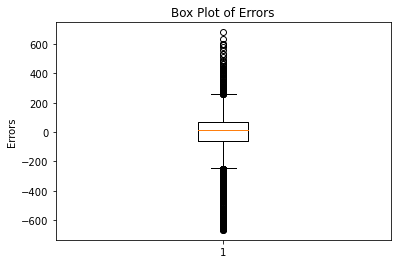

In [93]:
# Create a box plot of errors
plt.boxplot(errors)
plt.ylabel("Errors")
plt.title("Box Plot of Errors")
plt.show()